In [609]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [610]:
RANDOM_SEED = 42
TRAIN_CASE = 'daily_Confirmed'
TRAIN_LOCATION="Kerala"
TRAIN_LOCATION1="Delhi"
TRAIN_LOCATION2="Tamil Nadu"
DATATRAIN_SOURCE_FILE ='covid_19_india.csv'
TEST_SIZE = 0.3
LOOK_BACK = 1
BATCH_SIZE = 1
EPOCHS = 500
DAYS_TO_PREDICT = 30

In [611]:
np.random.seed(RANDOM_SEED)

In [612]:
df = pd.read_csv(DATATRAIN_SOURCE_FILE)


In [613]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [614]:
nan_values_array = []
for column in df:
     nan_values_array.append(df[column].isnull().sum())

In [615]:
column_names = list(df.columns.values)
data = {'Feature':column_names,'Number of NaN values':nan_values_array}
nan_values = pd.DataFrame(data)
print(nan_values)

                    Feature  Number of NaN values
0                       Sno                     0
1                      Date                     0
2                      Time                     0
3      State/UnionTerritory                     0
4   ConfirmedIndianNational                     0
5  ConfirmedForeignNational                     0
6                     Cured                     0
7                    Deaths                     0
8                 Confirmed                     0


In [616]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")

In [617]:
ex = np.unique(df['State/UnionTerritory'])
ex

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Bihar****',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Himanchal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karanataka', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Madhya Pradesh***', 'Maharashtra',
       'Maharashtra***', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Telengana', 'Tripura', 'Unassigned',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [618]:
def clean_stateName(stateName):
    if stateName == 'Telangana':
        stateName = 'Telangana'
    elif stateName == 'Telengana':
        stateName = 'Telangana'  
    elif stateName == 'Bihar****':
        stateName = 'Bihar'
    elif stateName == 'Himanchal Pradesh':
        stateName = 'Himachal Pradesh'
    elif stateName == 'Karanataka':
        stateName = 'Karnataka'
    elif stateName == 'Madhya Pradesh***':
        stateName = 'Madhya Pradesh'
    elif stateName == 'Maharashtra***':
        stateName = 'Maharashtra'
    return stateName

In [619]:
df["State/UnionTerritory"] = df["State/UnionTerritory"].apply(lambda x: clean_stateName(x))
np.unique(df["State/UnionTerritory"])

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Unassigned', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [620]:
def daily_cases(dframe, stateColumn,dateColumn, cummColumn):
    
    dframe.sort_values(by = [stateColumn, dateColumn], inplace = True)
    newColName = 'daily_' + cummColumn
    dframe[newColName] = dframe[cummColumn].diff() 
    
    mask = dframe[stateColumn] != dframe[stateColumn].shift(1)
    dframe[newColName][mask] = np.nan 
    dframe[newColName] = dframe[newColName].apply(lambda x: 0 if x < 0 else x) 

    
    return dframe

In [621]:
df_new = daily_cases(dframe= df, stateColumn= 'State/UnionTerritory',dateColumn= 'Date', cummColumn= 'Confirmed')

C:\Users\sephy\AppData\Local\Temp/ipykernel_7140/3238246320.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe[newColName][mask] = np.nan


In [622]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18070 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [623]:
df_new['daily_Confirmed'].fillna(value=df_new['daily_Confirmed'].mean(),inplace=True)

In [624]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [625]:
corrmat=df_new.corr()[df_new.corr(method='pearson')>0.6]                 
print(corrmat)


                 Sno     Cured    Deaths  Confirmed  daily_Confirmed
Sno              1.0       NaN       NaN        NaN              NaN
Cured            NaN  1.000000  0.917529   0.997751              NaN
Deaths           NaN  0.917529  1.000000   0.918346              NaN
Confirmed        NaN  0.997751  0.918346   1.000000              NaN
daily_Confirmed  NaN       NaN       NaN        NaN              1.0


In [626]:
def correlation(dataset, threshold): 
    col_corr = set() 
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold): 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr
#    
corr_feature=correlation(df,0.6)
len(set(corr_feature))


2

In [627]:
corr_feature

{'Confirmed', 'Deaths'}

In [628]:
df_new.drop(['Confirmed','Deaths'],axis=1,inplace=True)

In [629]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ MB


In [630]:

if TRAIN_LOCATION2:
    df_new = df_new.loc[df_new['State/UnionTerritory']==TRAIN_LOCATION2]


In [631]:
df_new.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,daily_Confirmed
61,62,2020-03-07,6:00 PM,Tamil Nadu,1,0,0,1777.163863
67,68,2020-03-08,6:00 PM,Tamil Nadu,1,0,0,0.000000
79,80,2020-03-09,6:00 PM,Tamil Nadu,1,0,0,0.000000
94,95,2020-03-10,6:00 PM,Tamil Nadu,1,0,0,0.000000
105,106,2020-03-11,6:00 PM,Tamil Nadu,1,0,0,0.000000


In [632]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 61 to 18104
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       523 non-null    int64         
 1   Date                      523 non-null    datetime64[ns]
 2   Time                      523 non-null    object        
 3   State/UnionTerritory      523 non-null    object        
 4   ConfirmedIndianNational   523 non-null    object        
 5   ConfirmedForeignNational  523 non-null    object        
 6   Cured                     523 non-null    int64         
 7   daily_Confirmed           523 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 36.8+ KB


Gettin train case & removing all zero values

In [633]:
cases = df_new.filter([TRAIN_CASE])
cases = cases[(cases.T != 0).any()]

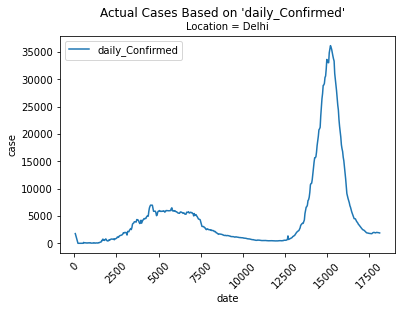

In [634]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION1, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [635]:
cases.shape

(509, 1)

In [636]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [637]:
test_size = TEST_SIZE
test_size = int(cases.shape[0] * test_size)
train_cases = cases[:-test_size]
test_cases = cases[-test_size:]

In [638]:
train_cases.shape

(357, 1)

In [639]:
test_cases.shape

(152, 1)

Data normalization

In [640]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases)
all_cases = scaler.transform(cases)
train_cases = scaler.transform(train_cases)
test_cases = scaler.transform(test_cases)

In [641]:
all_cases.shape

(509, 1)

In [642]:
train_cases.shape

(357, 1)

In [643]:
test_cases.shape

(152, 1)

Splitting data to get X & Y value

In [644]:
look_back = LOOK_BACK
X_all, Y_all = data_split(all_cases, look_back=look_back)
X_train, Y_train = data_split(train_cases, look_back=look_back)
X_test, Y_test = data_split(test_cases, look_back=look_back)

In [645]:
X_all.shape

(507, 1)

In [646]:
X_train.shape

(355, 1)

In [647]:
X_test.shape

(150, 1)

In [648]:
X_all = np.array(X_all).reshape(X_all.shape[0], 1, 1)
Y_all = np.array(Y_all).reshape(Y_all.shape[0], 1)
X_train = np.array(X_train).reshape(X_train.shape[0], 1, 1)
Y_train = np.array(Y_train).reshape(Y_train.shape[0], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 1, 1)
Y_test = np.array(Y_test).reshape(Y_test.shape[0], 1)

In [649]:
X_all.shape

(507, 1, 1)

In [650]:
Y_all.shape

(507, 1)

In [651]:
X_train.shape

(355, 1, 1)

In [652]:
Y_train.shape

(355, 1)

In [653]:
X_test.shape

(150, 1, 1)

In [654]:
Y_test.shape

(150, 1)

In [655]:
from keras.layers import Bidirectional
from keras.optimizers import Adam
batch_size = BATCH_SIZE

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.10))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 1, 256)           133120    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 1, 256)            0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 297,601
Trainable params: 297,601
Non-t

C:\Users\sephy\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [656]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_train, Y_train, batch_size=1, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    
    model.reset_states()

Iteration 1/500
355/355 [==============================] - 7s 6ms/step - loss: 0.0396
Iteration 2/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0014
Iteration 3/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0016
Iteration 4/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0019
Iteration 5/500
355/355 [==============================] - 2s 4ms/step - loss: 0.0013
Iteration 6/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0014
Iteration 7/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0015
Iteration 8/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0014
Iteration 9/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0012
Iteration 10/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0013
Iteration 11/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0015
Iteration 12/500
355/355 [==========================

355/355 [==============================] - 2s 5ms/step - loss: 0.0051
Iteration 95/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0046
Iteration 96/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0038
Iteration 97/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0033
Iteration 98/500
355/355 [==============================] - 2s 4ms/step - loss: 0.0031
Iteration 99/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0028
Iteration 100/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0024
Iteration 101/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0024
Iteration 102/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0021
Iteration 103/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0018
Iteration 104/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0018
Iteration 105/500
355/355 [============================

355/355 [==============================] - 2s 5ms/step - loss: 6.0476e-04
Iteration 274/500
355/355 [==============================] - 1s 4ms/step - loss: 5.8957e-04
Iteration 275/500
355/355 [==============================] - 2s 5ms/step - loss: 5.7224e-04
Iteration 276/500
355/355 [==============================] - 2s 5ms/step - loss: 5.9455e-04
Iteration 277/500
355/355 [==============================] - 2s 5ms/step - loss: 5.8681e-04
Iteration 278/500
355/355 [==============================] - 2s 5ms/step - loss: 5.8367e-04
Iteration 279/500
355/355 [==============================] - 2s 5ms/step - loss: 5.9452e-04
Iteration 280/500
355/355 [==============================] - 2s 5ms/step - loss: 5.8676e-04
Iteration 281/500
355/355 [==============================] - 2s 5ms/step - loss: 5.6707e-04
Iteration 282/500
355/355 [==============================] - 2s 5ms/step - loss: 5.5995e-04
Iteration 283/500
355/355 [==============================] - 2s 5ms/step - loss: 5.7407e-04
Iterat

355/355 [==============================] - 2s 5ms/step - loss: 5.3494e-04
Iteration 452/500
355/355 [==============================] - 2s 5ms/step - loss: 5.2479e-04
Iteration 453/500
355/355 [==============================] - 2s 5ms/step - loss: 5.0601e-04
Iteration 454/500
355/355 [==============================] - 2s 5ms/step - loss: 5.3388e-04
Iteration 455/500
355/355 [==============================] - 2s 5ms/step - loss: 4.6292e-04
Iteration 456/500
355/355 [==============================] - 2s 5ms/step - loss: 5.4166e-04
Iteration 457/500
355/355 [==============================] - 2s 5ms/step - loss: 4.6170e-04
Iteration 458/500
355/355 [==============================] - 2s 5ms/step - loss: 4.7352e-04
Iteration 459/500
355/355 [==============================] - 2s 5ms/step - loss: 4.4886e-04
Iteration 460/500
355/355 [==============================] - 2s 5ms/step - loss: 5.1348e-04
Iteration 461/500
355/355 [==============================] - 2s 4ms/step - loss: 4.9355e-04
Iterat

Plotting model loss history

Lower `loss` provide better prediction

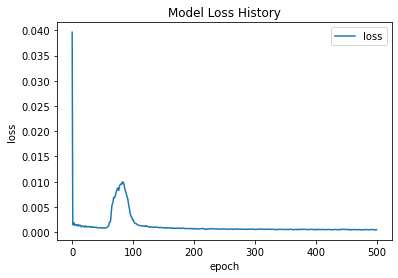

In [657]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [658]:
train_predict = model.predict(X_train, batch_size=batch_size)

355/355 [==============================] - 2s 2ms/step


In [659]:
days_to_predict = X_test.shape[0]
test_predict = []
pred_samples = train_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(X_test[i:(i+1)], batch_size=batch_size)
    pred = np.array(pred).flatten()
    test_predict.append(pred)
test_predict = np.array(test_predict).reshape(1, len(test_predict), 1)

1/1 [==============================] - 0s 25ms/step


In [660]:
model.reset_states()

In [661]:
X_train_flatten = np.array(scaler.inverse_transform(
    np.array(X_train).reshape(X_train.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten = np.array(scaler.inverse_transform(
    np.array(Y_train).reshape(Y_train.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten = np.array(scaler.inverse_transform(
    np.array(train_predict).reshape(train_predict.shape[0], 1)
)).flatten().astype('int')
X_test_flatten = np.array(scaler.inverse_transform(
    np.array(X_test).reshape(X_test.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten = np.array(scaler.inverse_transform(
    np.array(Y_test).reshape(Y_test.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten = np.array(scaler.inverse_transform(
    np.array(test_predict).reshape(test_predict.shape[1], 1)
)).flatten().astype('int')

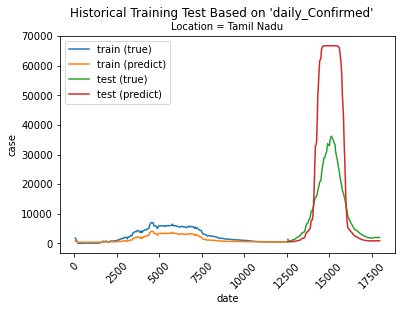

In [676]:
plt.plot(
    cases.index[:len(X_train_flatten)],
    X_train_flatten,
    label='train (true)'
)
plt.plot(
    cases.index[:len(train_predict_flatten)],
    train_predict_flatten,
    label='train (predict)'
)
plt.plot(
    cases.index[len(X_train_flatten):len(X_train_flatten) + len(X_test_flatten)],
    X_test_flatten,
    label='test (true)'
)
plt.plot(
    cases.index[len(X_train_flatten):len(X_train_flatten) + len(test_predict_flatten)],
    test_predict_flatten,
    label='test (predict)'
)
plt.suptitle('Historical Training Test Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION2, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [663]:
model.reset_states()

In [664]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_all, Y_all, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    
    model.reset_states()

Iteration 1/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0645
Iteration 2/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0292
Iteration 3/500
507/507 [==============================] - 2s 4ms/step - loss: 0.1706
Iteration 4/500
507/507 [==============================] - 2s 5ms/step - loss: 0.1749
Iteration 5/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0803
Iteration 6/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0141
Iteration 7/500
507/507 [==============================] - 2s 4ms/step - loss: 0.0095
Iteration 8/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0071
Iteration 9/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0077
Iteration 10/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0063
Iteration 11/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0063
Iteration 12/500
507/507 [==========================

507/507 [==============================] - 2s 5ms/step - loss: 0.0041
Iteration 189/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0027
Iteration 190/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0038
Iteration 191/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0037
Iteration 192/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0045
Iteration 193/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0026
Iteration 194/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0051
Iteration 195/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0030
Iteration 196/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0034
Iteration 197/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0043
Iteration 198/500
507/507 [==============================] - 2s 5ms/step - loss: 0.0040
Iteration 199/500
507/507 [=======================

507/507 [==============================] - 1s 2ms/step - loss: 0.0027
Iteration 375/500
507/507 [==============================] - 1s 2ms/step - loss: 0.0035
Iteration 376/500
507/507 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 377/500
507/507 [==============================] - 1s 2ms/step - loss: 0.0036
Iteration 378/500
507/507 [==============================] - 1s 2ms/step - loss: 0.0022
Iteration 379/500
507/507 [==============================] - 1s 3ms/step - loss: 0.0028
Iteration 380/500
507/507 [==============================] - 1s 3ms/step - loss: 0.0029
Iteration 381/500
507/507 [==============================] - 1s 3ms/step - loss: 0.0025
Iteration 382/500
507/507 [==============================] - 1s 3ms/step - loss: 0.0032
Iteration 383/500
507/507 [==============================] - 1s 3ms/step - loss: 0.0032
Iteration 384/500
507/507 [==============================] - 1s 2ms/step - loss: 0.0023
Iteration 385/500
507/507 [=======================

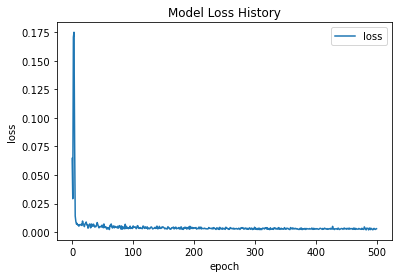

In [665]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [666]:
all_predict = model.predict(X_all, batch_size=batch_size)

507/507 [==============================] - 0s 788us/step


In [667]:
days_to_predict = DAYS_TO_PREDICT
future_predict = []
pred_samples = all_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(pred_samples, batch_size=batch_size)
    pred = np.array(pred).flatten()
    future_predict.append(pred)
    new_samples = np.array(pred_samples).flatten()
    new_samples = np.append(new_samples, [pred])
    new_samples = new_samples[1:]
    pred_samples = np.array(new_samples).reshape(1, 1, 1)
future_predict = np.array(future_predict).reshape(len(future_predict), 1, 1)

1/1 [==============================] - 0s 13ms/step


In [668]:
model.reset_states()

In [669]:
f_future_predict = model.predict(future_predict, batch_size=batch_size)

30/30 [==============================] - 0s 1ms/step


In [670]:
model.reset_states()

In [671]:
X_all_flatten = np.array(scaler.inverse_transform(
    np.array(X_all).reshape(X_all.shape[0], 1)
)).flatten().astype('int')
X_all_flatten = np.absolute(X_all_flatten)
Y_all_flatten = np.array(scaler.inverse_transform(
    np.array(Y_all).reshape(Y_all.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten = np.absolute(Y_all_flatten)
all_predict_flatten = np.array(scaler.inverse_transform(
    np.array(all_predict).reshape(all_predict.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten = np.absolute(all_predict_flatten)
future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(future_predict).reshape(future_predict.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten = np.absolute(future_predict_flatten)
f_future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(f_future_predict).reshape(f_future_predict.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten = np.absolute(f_future_predict_flatten)

In [672]:
future_index = pd.date_range(start=cases.index[-1], periods=days_to_predict + 1, closed='right')

Plotting future prediction visualization

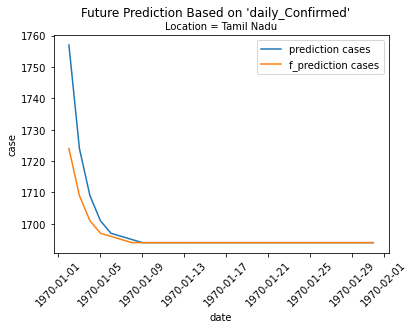

In [673]:
plt.plot(
    future_index,
    future_predict_flatten,
    label='prediction cases'
)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_prediction cases'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION2, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Plotting f_future prediction visualization

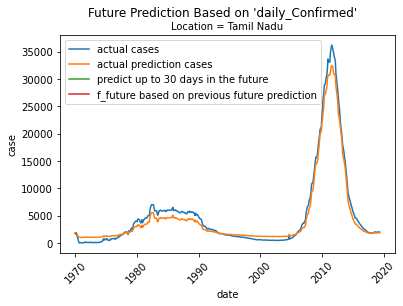

In [674]:
plt.plot(
    cases.index[:len(X_all_flatten)],
    X_all_flatten,
    label='actual cases'
)
plt.plot(
    cases.index[:len(X_all_flatten)],
    all_predict_flatten,
    label='actual prediction cases'
)
plt.plot(
    future_index,
    future_predict_flatten,
    label='predict up to ' + str(days_to_predict) + ' days in the future'
)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_future based on previous future prediction'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION2, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [675]:
#tn
def accuracy(DataY,preds):
    count = 0
    for i in range(len(DataY)):
        if( (preds[i] - DataY[i])/DataY[i]):
            count += 1
           
    return count/len(DataY)
accuracy( Y_all_flatten, 
        all_predict_flatten)

0.9783037475345168

In [543]:
df1= pd.read_csv(DATATRAIN_SOURCE_FILE)


In [544]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [545]:
df1["Date"] = pd.to_datetime(df1["Date"], format = "%Y-%m-%d")

In [546]:
ex = np.unique(df1['State/UnionTerritory'])
ex

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Bihar****',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Himanchal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karanataka', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Madhya Pradesh***', 'Maharashtra',
       'Maharashtra***', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Telengana', 'Tripura', 'Unassigned',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [547]:
def clean_stateName(stateName):
    if stateName == 'Telangana':
        stateName = 'Telangana'
    elif stateName == 'Telengana':
        stateName = 'Telangana'  
    elif stateName == 'Bihar****':
        stateName = 'Bihar'
    elif stateName == 'Himanchal Pradesh':
        stateName = 'Himachal Pradesh'
    elif stateName == 'Karanataka':
        stateName = 'Karnataka'
    elif stateName == 'Madhya Pradesh***':
        stateName = 'Madhya Pradesh'
    elif stateName == 'Maharashtra***':
        stateName = 'Maharashtra'
    return stateName

In [548]:
df1["State/UnionTerritory"] = df1["State/UnionTerritory"].apply(lambda x: clean_stateName(x))
np.unique(df1["State/UnionTerritory"]) # to identify all unique values in a column of dataframe or array

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Unassigned', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [549]:
def daily_cases(dframe, stateColumn,dateColumn, cummColumn):
    # Sort column containing state and then by date in ascending order
    dframe.sort_values(by = [stateColumn, dateColumn], inplace = True)
    newColName = 'daily_' + cummColumn
    dframe[newColName] = dframe[cummColumn].diff() # diff is pandas method to caclucate difference between consecutive values
#    print(dframe.tail())
    '''
    Below line uses shift method of pandas to compare consecutive state names and if they are not different
    as shown by using ! symbol then create list of boolean, True for if they are different else False
    ''' 
    mask = dframe[stateColumn] != dframe[stateColumn].shift(1)
    dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN
    dframe[newColName] = dframe[newColName].apply(lambda x: 0 if x < 0 else x) # replace negative values by 0
#     dframe.drop('diffs',axis=1, inplace = True)
    
    return dframe

In [550]:
df_new1 = daily_cases(dframe= df1, stateColumn= 'State/UnionTerritory',dateColumn= 'Date', cummColumn= 'Confirmed')

C:\Users\sephy\AppData\Local\Temp/ipykernel_7140/1035172673.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN


In [551]:
df_new1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18070 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [552]:
df_new1['daily_Confirmed'].fillna(value=df_new1['daily_Confirmed'].mean(),inplace=True)

In [553]:
corrmat=df_new1.corr()[df_new1.corr(method='pearson')>0.6]                  #Checking for highly correlated lab variables
print(corrmat)


                 Sno     Cured    Deaths  Confirmed  daily_Confirmed
Sno              1.0       NaN       NaN        NaN              NaN
Cured            NaN  1.000000  0.917529   0.997751              NaN
Deaths           NaN  0.917529  1.000000   0.918346              NaN
Confirmed        NaN  0.997751  0.918346   1.000000              NaN
daily_Confirmed  NaN       NaN       NaN        NaN              1.0


In [554]:
def correlation(dataset, threshold): 
    col_corr = set() 
    corr_matrix = df_new1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold): 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr
#    
corr_feature=correlation(df_new1,0.6)
len(set(corr_feature))


2

In [555]:
df_new1.drop(['Confirmed','Deaths'],axis=1,inplace=True)

In [556]:
df_new1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ MB


In [557]:
if TRAIN_LOCATION1:
    df_new1 = df_new1.loc[df_new1['State/UnionTerritory']==TRAIN_LOCATION1]

In [558]:
df_new1.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,daily_Confirmed
34,35,2020-03-02,6:00 PM,Delhi,1,0,0,1777.163863
38,39,2020-03-03,6:00 PM,Delhi,1,0,0,0.000000
42,43,2020-03-04,6:00 PM,Delhi,1,0,0,0.000000
45,46,2020-03-05,6:00 PM,Delhi,2,0,0,1.000000
51,52,2020-03-06,6:00 PM,Delhi,3,0,0,1.000000


In [559]:
cases1 = df_new1.filter([TRAIN_CASE])
cases1 = cases1[(cases1.T != 0).any()]


In [560]:
cases1.head()

,daily_Confirmed
34,1777.163863
45,1.000000
51,1.000000
84,1.000000
98,1.000000


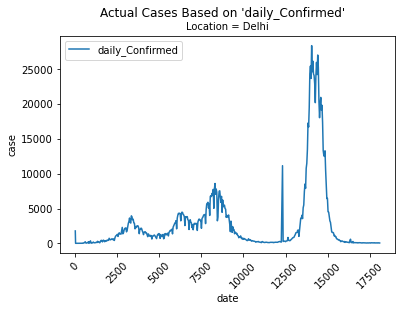

In [561]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION1, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [562]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [563]:
test_size1 = TEST_SIZE
test_size1 = int(cases1.shape[0] * test_size1)
train_cases1 = cases1[:-test_size1]
test_cases1 = cases1[-test_size1:]

In [564]:
train_cases1.shape


(359, 1)

In [565]:
test_cases1.shape

(153, 1)

In [566]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases1)
all_cases1 = scaler.transform(cases1)
train_cases1 = scaler.transform(train_cases1)
test_cases1 = scaler.transform(test_cases1)

In [567]:
all_cases1.shape

(512, 1)

In [568]:
train_cases1.shape

(359, 1)

In [569]:
test_cases1.shape

(153, 1)

In [570]:
look_back = LOOK_BACK
X_all1, Y_all1 = data_split(all_cases1, look_back=look_back)
X_train1, Y_train1 = data_split(train_cases1, look_back=look_back)
X_test1, Y_test1 = data_split(test_cases1, look_back=look_back)

In [571]:
X_all1.shape

(510, 1)

In [572]:
X_train1.shape

(357, 1)

In [573]:
X_test1.shape

(151, 1)

In [574]:
X_all1 = np.array(X_all1).reshape(X_all1.shape[0], 1, 1)
Y_all1 = np.array(Y_all1).reshape(Y_all1.shape[0], 1)
X_train1 = np.array(X_train1).reshape(X_train1.shape[0], 1, 1)
Y_train1 = np.array(Y_train1).reshape(Y_train1.shape[0], 1)
X_test1 = np.array(X_test1).reshape(X_test1.shape[0], 1, 1)
Y_test1 = np.array(Y_test1).reshape(Y_test1.shape[0], 1)

In [575]:
X_all1.shape

(510, 1, 1)

In [576]:
Y_all1.shape

(510, 1)

In [577]:
X_train1.shape

(357, 1, 1)

In [578]:
Y_test1.shape

(151, 1)

In [579]:
Y_train1.shape

(357, 1)

In [580]:
X_test1.shape

(151, 1, 1)

In [581]:
from keras.layers import Bidirectional
from keras.optimizers import Adam
batch_size = BATCH_SIZE

model2 = Sequential()
model2.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train1.shape[1], X_train1.shape[2])))
model2.add(Dropout(0.10))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dropout(0.10))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 1, 256)           133120    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 1, 256)            0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 297,601
Trainable params: 297,601
Non-t

C:\Users\sephy\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [582]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model2.fit(X_train1, Y_train1, batch_size=1, 
              epochs=1, verbose=1, shuffle=False)
    h1 = model2.history
    loss.append(h1.history['loss'][0])
    
    model2.reset_states()

Iteration 1/500
357/357 [==============================] - 3s 2ms/step - loss: 0.0458
Iteration 2/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0054
Iteration 3/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0054
Iteration 4/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0049
Iteration 5/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0057
Iteration 6/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0052
Iteration 7/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0053
Iteration 8/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0053
Iteration 9/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0057
Iteration 10/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0061
Iteration 11/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0065
Iteration 12/500
357/357 [==========================

357/357 [==============================] - 1s 2ms/step - loss: 0.0042
Iteration 189/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0043
Iteration 190/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0041
Iteration 191/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0043
Iteration 192/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0042
Iteration 193/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0043
Iteration 194/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0041
Iteration 195/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0043
Iteration 196/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0042
Iteration 197/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0042
Iteration 198/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0042
Iteration 199/500
357/357 [=======================

357/357 [==============================] - 1s 2ms/step - loss: 0.0037
Iteration 375/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 376/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 377/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 378/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0038
Iteration 379/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 380/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 381/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0037
Iteration 382/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0038
Iteration 383/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 384/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 385/500
357/357 [=======================

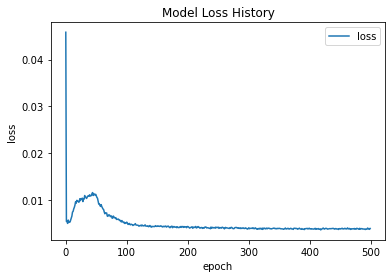

In [583]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [584]:
train_predict1= model2.predict(X_train1, batch_size=batch_size)

357/357 [==============================] - 1s 784us/step


In [585]:
days_to_predict1 = X_test1.shape[0]
test_predict1 = []
pred_samples1 = train_predict1[-1:]
pred_samples1 = np.array([pred_samples1])
for i in range(days_to_predict1):
    pred1 = model2.predict(X_test1[i:(i+1)], batch_size=batch_size)
    pred1 = np.array(pred1).flatten()
    test_predict1.append(pred1)
test_predict1 = np.array(test_predict1).reshape(1, len(test_predict1), 1)

1/1 [==============================] - 0s 13ms/step


In [586]:
model2.reset_states()

In [587]:
X_train_flatten1 = np.array(scaler.inverse_transform(
    np.array(X_train1).reshape(X_train1.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten1 = np.array(scaler.inverse_transform(
    np.array(Y_train1).reshape(Y_train1.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(train_predict1).reshape(train_predict1.shape[0], 1)
)).flatten().astype('int')
X_test_flatten1 = np.array(scaler.inverse_transform(
    np.array(X_test1).reshape(X_test1.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten1 = np.array(scaler.inverse_transform(
    np.array(Y_test1).reshape(Y_test1.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(test_predict1).reshape(test_predict1.shape[1], 1)
)).flatten().astype('int')

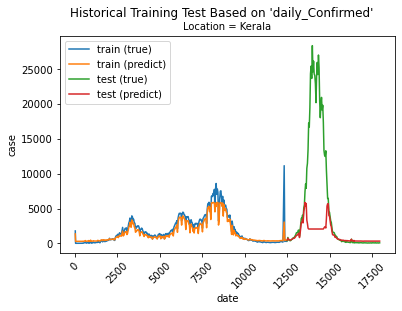

In [588]:
plt.plot(
    cases.index[:len(X_train_flatten1)],
    X_train_flatten1,
    label='train (true)'
)
plt.plot(
    cases.index[:len(train_predict_flatten1)],
    train_predict_flatten1,
    label='train (predict)'
)
plt.plot(
    cases.index[len(X_train_flatten1):len(X_train_flatten1) + len(X_test_flatten1)],
    X_test_flatten1,
    label='test (true)'
)
plt.plot(
    cases.index[len(X_train_flatten1):len(X_train_flatten1) + len(test_predict_flatten1)],
    test_predict_flatten1,
    label='test (predict)'
)
plt.suptitle('Historical Training Test Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [589]:
model2.reset_states()

In [590]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model2.fit(X_all1, Y_all1, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h1 = model2.history
    loss.append(h1.history['loss'][0])
    
    model2.reset_states()

Iteration 1/500
510/510 [==============================] - 1s 2ms/step - loss: 0.1023
Iteration 2/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0828
Iteration 3/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0702
Iteration 4/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0611
Iteration 5/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0531
Iteration 6/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0471
Iteration 7/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0420
Iteration 8/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0372
Iteration 9/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0330
Iteration 10/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0303
Iteration 11/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0223
Iteration 12/500
510/510 [==========================

510/510 [==============================] - 1s 2ms/step - loss: 0.0071
Iteration 189/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0074
Iteration 190/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0083
Iteration 191/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0083
Iteration 192/500
510/510 [==============================] - 1s 3ms/step - loss: 0.0070
Iteration 193/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0074
Iteration 194/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0092
Iteration 195/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0071
Iteration 196/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0068
Iteration 197/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0088
Iteration 198/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0087
Iteration 199/500
510/510 [=======================

510/510 [==============================] - 1s 2ms/step - loss: 0.0069
Iteration 375/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0069
Iteration 376/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0076
Iteration 377/500
510/510 [==============================] - 1s 3ms/step - loss: 0.0065
Iteration 378/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0067
Iteration 379/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0068
Iteration 380/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0063
Iteration 381/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0077
Iteration 382/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0076
Iteration 383/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0065
Iteration 384/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0079
Iteration 385/500
510/510 [=======================

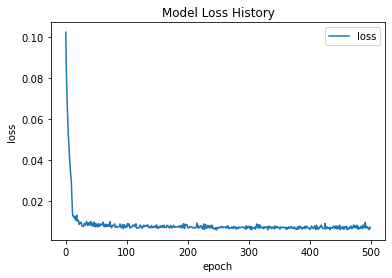

In [591]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [592]:
all_predict1 = model.predict(X_all1, batch_size=batch_size)

510/510 [==============================] - 1s 951us/step


In [593]:
days_to_predict1 = DAYS_TO_PREDICT
future_predict1 = []
pred_samples1 = all_predict1[-1:]
pred_samples1 = np.array([pred_samples1])
for i in range(days_to_predict1):
    pred1 = model2.predict(pred_samples1, batch_size=batch_size)
    pred1 = np.array(pred1).flatten()
    future_predict1.append(pred1)
    new_samples1 = np.array(pred_samples1).flatten()
    new_samples1 = np.append(new_samples1, [pred1])
    new_samples1 = new_samples1[1:]
    pred_samples1 = np.array(new_samples1).reshape(1, 1, 1)
future_predict1 = np.array(future_predict1).reshape(len(future_predict1), 1, 1)

1/1 [==============================] - 0s 16ms/step


In [594]:
model2.reset_states()

In [595]:
f_future_predict1 = model2.predict(future_predict1, batch_size=batch_size)

30/30 [==============================] - 0s 1ms/step


In [596]:
model2.reset_states()

In [597]:
X_all_flatten1 = np.array(scaler.inverse_transform(
    np.array(X_all1).reshape(X_all1.shape[0], 1)
)).flatten().astype('int')
X_all_flatten1 = np.absolute(X_all_flatten1)
Y_all_flatten1= np.array(scaler.inverse_transform(
    np.array(Y_all1).reshape(Y_all1.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten1 = np.absolute(Y_all_flatten1)
all_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(all_predict1).reshape(all_predict1.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten1 = np.absolute(all_predict_flatten1)
future_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(future_predict1).reshape(future_predict1.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten1 = np.absolute(future_predict_flatten1)
f_future_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(f_future_predict1).reshape(f_future_predict1.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten1 = np.absolute(f_future_predict_flatten1)

In [598]:
future_index1 = pd.date_range(start=cases.index[-1], periods=days_to_predict1 + 1, closed='right')

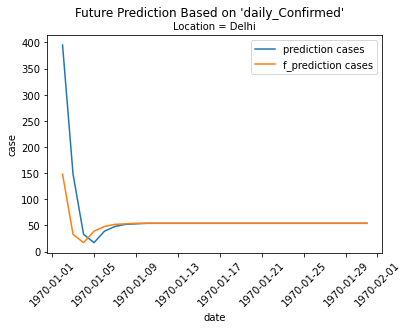

In [602]:
plt.plot(
    future_index1,
    future_predict_flatten1,
    label='prediction cases'
)
plt.plot(
    future_index1,
    f_future_predict_flatten1,
    label='f_prediction cases'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION1, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

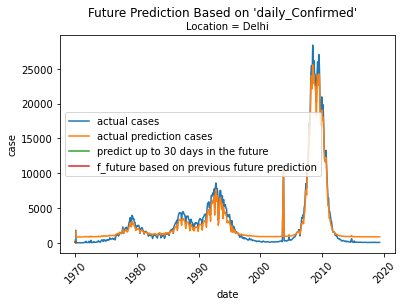

In [605]:
plt.plot(
    cases.index[:len(X_all_flatten1)],
    X_all_flatten1,
    label='actual cases'
)
plt.plot(
    cases.index[:len(X_all_flatten1)],
    all_predict_flatten1,
    label='actual prediction cases'
)
plt.plot(
    future_index1,
    future_predict_flatten1,
    label='predict up to ' + str(days_to_predict1) + ' days in the future'
)
plt.plot(
    future_index1,
    f_future_predict_flatten1,
    label='f_future based on previous future prediction'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION1, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [601]:
#delhi
def accuracy(DataY,preds):
    count = 0
    for i in range(len(DataY)):
        if( (preds[i] - DataY[i])/DataY[i]<95):
            count += 1
           
    return count/len(DataY)
accuracy( Y_all_flatten1, 
        all_predict_flatten1)

0.9686274509803922

In [454]:
df3= pd.read_csv(DATATRAIN_SOURCE_FILE)


In [455]:
df3["Date"] = pd.to_datetime(df3["Date"], format = "%Y-%m-%d")

In [456]:
ex = np.unique(df3['State/UnionTerritory'])
ex

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Bihar****',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Himanchal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karanataka', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Madhya Pradesh***', 'Maharashtra',
       'Maharashtra***', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Telengana', 'Tripura', 'Unassigned',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [457]:
def clean_stateName(stateName):
    if stateName == 'Telangana':
        stateName = 'Telangana'
    elif stateName == 'Telengana':
        stateName = 'Telangana'  
    elif stateName == 'Bihar****':
        stateName = 'Bihar'
    elif stateName == 'Himanchal Pradesh':
        stateName = 'Himachal Pradesh'
    elif stateName == 'Karanataka':
        stateName = 'Karnataka'
    elif stateName == 'Madhya Pradesh***':
        stateName = 'Madhya Pradesh'
    elif stateName == 'Maharashtra***':
        stateName = 'Maharashtra'
    return stateName

In [458]:
df3["State/UnionTerritory"] = df3["State/UnionTerritory"].apply(lambda x: clean_stateName(x))
np.unique(df3["State/UnionTerritory"]) # to identify all unique values in a column of dataframe or array

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Unassigned', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [459]:
def daily_cases(dframe, stateColumn,dateColumn, cummColumn):
    # Sort column containing state and then by date in ascending order
    dframe.sort_values(by = [stateColumn, dateColumn], inplace = True)
    newColName = 'daily_' + cummColumn
    dframe[newColName] = dframe[cummColumn].diff() # diff is pandas method to caclucate difference between consecutive values
#    print(dframe.tail())
    '''
    Below line uses shift method of pandas to compare consecutive state names and if they are not different
    as shown by using ! symbol then create list of boolean, True for if they are different else False
    ''' 
    mask = dframe[stateColumn] != dframe[stateColumn].shift(1)
    dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN
    dframe[newColName] = dframe[newColName].apply(lambda x: 0 if x < 0 else x) # replace negative values by 0
#     dframe.drop('diffs',axis=1, inplace = True)
    
    return dframe

In [460]:
df_new3 = daily_cases(dframe= df3, stateColumn= 'State/UnionTerritory',dateColumn= 'Date', cummColumn= 'Confirmed')

C:\Users\sephy\AppData\Local\Temp/ipykernel_7140/1035172673.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN


In [461]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18070 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [462]:
df_new3['daily_Confirmed'].fillna(value=df_new3['daily_Confirmed'].mean(),inplace=True)

In [463]:
corrmat=df_new3.corr()[df_new3.corr(method='pearson')>0.6]                  #Checking for highly correlated lab variables
print(corrmat)


                 Sno     Cured    Deaths  Confirmed  daily_Confirmed
Sno              1.0       NaN       NaN        NaN              NaN
Cured            NaN  1.000000  0.917529   0.997751              NaN
Deaths           NaN  0.917529  1.000000   0.918346              NaN
Confirmed        NaN  0.997751  0.918346   1.000000              NaN
daily_Confirmed  NaN       NaN       NaN        NaN              1.0


In [464]:
def correlation(dataset, threshold): 
    col_corr = set() 
    corr_matrix = df_new3.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold): 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr
#    
corr_feature=correlation(df_new3,0.6)
len(set(corr_feature))


2

In [465]:
df_new3.drop(['Confirmed','Deaths'],axis=1,inplace=True)

In [466]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ MB


In [480]:
if TRAIN_LOCATION:
    df_new3 = df_new3.loc[df_new3['State/UnionTerritory']==TRAIN_LOCATION]

In [481]:
df_new3.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,daily_Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,1777.163863
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0.000000
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,1.000000
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,1.000000
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0.000000


In [482]:
cases3 = df_new3.filter([TRAIN_CASE])
cases3 = cases3[(cases3.T != 0).any()]
cases3.head()

,daily_Confirmed
0,1777.163863
2,1.000000
3,1.000000
69,5.000000
75,1.000000


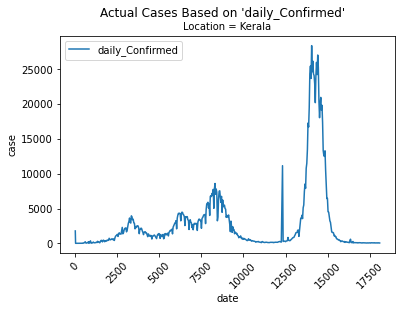

In [483]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [484]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [485]:
test_size3 = TEST_SIZE
test_size3 = int(cases3.shape[0] * test_size3)
train_cases3 = cases3[:-test_size3]
test_cases3 = cases[-test_size3:]

In [486]:
train_cases3.shape


(361, 1)

In [487]:
test_cases3.shape

(154, 1)

In [488]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases3)
all_cases3 = scaler.transform(cases3)
train_cases3 = scaler.transform(train_cases3)
test_cases3 = scaler.transform(test_cases3)

In [489]:
all_cases3.shape

(515, 1)

In [490]:
train_cases3.shape

(361, 1)

In [491]:
test_cases3.shape

(154, 1)

In [492]:
look_back = LOOK_BACK
X_all3, Y_all3 = data_split(all_cases3, look_back=look_back)
X_train3, Y_train3 = data_split(train_cases3, look_back=look_back)
X_test3, Y_test3 = data_split(test_cases3, look_back=look_back)

In [493]:
X_all3.shape

(513, 1)

In [494]:
Y_all3.shape

(513,)

In [495]:
X_train3.shape

(359, 1)

In [496]:
Y_train3.shape

(359,)

In [497]:
X_test3.shape

(152, 1)

In [498]:
Y_test3.shape

(152,)

In [499]:
X_all3 = np.array(X_all3).reshape(X_all3.shape[0], 1, 1)
Y_all3 = np.array(Y_all3).reshape(Y_all3.shape[0], 1)
X_train3 = np.array(X_train3).reshape(X_train3.shape[0], 1, 1)
Y_train3 = np.array(Y_train3).reshape(Y_train3.shape[0], 1)
X_test3 = np.array(X_test3).reshape(X_test3.shape[0], 1, 1)
Y_test3 = np.array(Y_test3).reshape(Y_test3.shape[0], 1)

In [504]:
X_all3.shape

(513, 1, 1)

In [505]:
Y_all3.shape

(513, 1)

In [506]:
X_train3.shape

(359, 1, 1)

In [507]:
X_test3.shape

(152, 1, 1)

In [508]:
Y_train3.shape

(359, 1)

In [509]:
Y_test3.shape

(152, 1)

In [510]:
from keras.layers import Bidirectional
from keras.optimizers import Adam
batch_size = BATCH_SIZE

model3= Sequential()
model3.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train3.shape[1], X_train3.shape[2])))
model3.add(Dropout(0.10))
model3.add(Bidirectional(LSTM(64)))
model3.add(Dropout(0.10))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 1, 256)           133120    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 1, 256)            0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 297,601
Trainable params: 297,601
Non-t

C:\Users\sephy\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [511]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model3.fit(X_train3, Y_train3, batch_size=1, 
              epochs=1, verbose=1, shuffle=False)
    h3 = model3.history
    loss.append(h3.history['loss'][0])
    
    model3.reset_states()

Iteration 1/500
359/359 [==============================] - 3s 2ms/step - loss: 0.0444
Iteration 2/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0033
Iteration 3/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0036
Iteration 4/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0030
Iteration 5/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0031
Iteration 6/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0029
Iteration 7/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0028
Iteration 8/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0027
Iteration 9/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 10/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0028
Iteration 11/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 12/500
359/359 [==========================

359/359 [==============================] - 1s 3ms/step - loss: 0.0028
Iteration 189/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0029
Iteration 190/500
359/359 [==============================] - 1s 4ms/step - loss: 0.0029
Iteration 191/500
359/359 [==============================] - 1s 4ms/step - loss: 0.0028
Iteration 192/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0028
Iteration 193/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0029
Iteration 194/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0028
Iteration 195/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0028
Iteration 196/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0027
Iteration 197/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0028
Iteration 198/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0027
Iteration 199/500
359/359 [=======================

359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 375/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 376/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 377/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0025
Iteration 378/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 379/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 380/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 381/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0025
Iteration 382/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0025
Iteration 383/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0027
Iteration 384/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0026
Iteration 385/500
359/359 [=======================

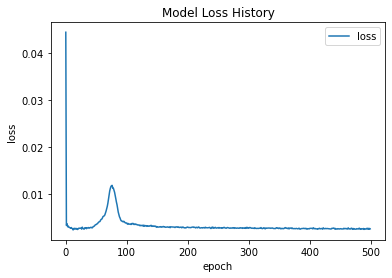

In [512]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [513]:
train_predict3 = model3.predict(X_train3, batch_size=batch_size)

359/359 [==============================] - 1s 816us/step


In [514]:
days_to_predict3 = X_test3.shape[0]
test_predict3 = []
pred_samples3 = train_predict3[-1:]
pred_samples3 = np.array([pred_samples3])
for i in range(days_to_predict3):
    pred3 = model3.predict(X_test3[i:(i+1)], batch_size=batch_size)
    pred3 = np.array(pred3).flatten()
    test_predict3.append(pred3)
test_predict3 = np.array(test_predict3).reshape(1, len(test_predict3), 1)

1/1 [==============================] - 0s 13ms/step


In [515]:
model3.reset_states()

In [516]:
X_train_flatten3 = np.array(scaler.inverse_transform(
    np.array(X_train3).reshape(X_train3.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten3 = np.array(scaler.inverse_transform(
    np.array(Y_train3).reshape(Y_train3.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(train_predict3).reshape(train_predict3.shape[0], 1)
)).flatten().astype('int')
X_test_flatten3 = np.array(scaler.inverse_transform(
    np.array(X_test3).reshape(X_test3.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten3 = np.array(scaler.inverse_transform(
    np.array(Y_test3).reshape(Y_test3.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(test_predict3).reshape(test_predict3.shape[1], 1)
)).flatten().astype('int')

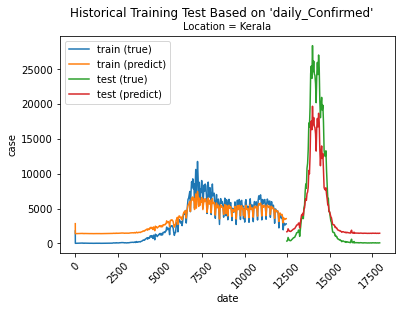

In [538]:
plt.plot(
    cases3.index[:len(X_train_flatten3)],
    X_train_flatten3,
    label='train (true)'
)
plt.plot(
    cases3.index[:len(train_predict_flatten3)],
    train_predict_flatten3,
    label='train (predict)'
)
plt.plot(
    cases3.index[len(X_train_flatten3):len(X_train_flatten3) + len(X_test_flatten3)],
    X_test_flatten3,
    label='test (true)'
)
plt.plot(
    cases3.index[len(X_train_flatten3):len(X_train_flatten3) + len(test_predict_flatten3)],
    test_predict_flatten3,
    label='test (predict)'
)
plt.suptitle('Historical Training Test Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [518]:
model3.reset_states()

In [519]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model3.fit(X_all3, Y_all3, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h3 = model3.history
    loss.append(h3.history['loss'][0])
    
    model3.reset_states()

Iteration 1/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0187
Iteration 2/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0174
Iteration 3/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0162
Iteration 4/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0196
Iteration 5/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0181
Iteration 6/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0156
Iteration 7/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0153
Iteration 8/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0171
Iteration 9/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0151
Iteration 10/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0149
Iteration 11/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0179
Iteration 12/500
513/513 [==========================

513/513 [==============================] - 1s 2ms/step - loss: 0.0116
Iteration 189/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0122
Iteration 190/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0128
Iteration 191/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0129
Iteration 192/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0124
Iteration 193/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0132
Iteration 194/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0141
Iteration 195/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0121
Iteration 196/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0126
Iteration 197/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0115
Iteration 198/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0116
Iteration 199/500
513/513 [=======================

513/513 [==============================] - 1s 2ms/step - loss: 0.0118
Iteration 375/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0114
Iteration 376/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0119
Iteration 377/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0120
Iteration 378/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0120
Iteration 379/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0128
Iteration 380/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0121
Iteration 381/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0120
Iteration 382/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0113
Iteration 383/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0122
Iteration 384/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0118
Iteration 385/500
513/513 [=======================

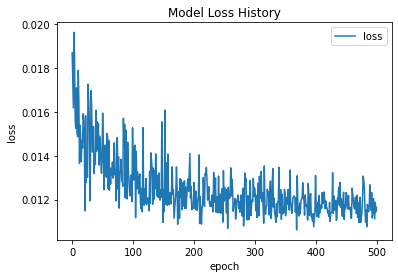

In [520]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [521]:
all_predict3 = model3.predict(X_all3, batch_size=batch_size)

513/513 [==============================] - 1s 1ms/step


In [529]:
days_to_predict3 = DAYS_TO_PREDICT
future_predict3 = []
pred_samples3 = all_predict3[-1:]
pred_samples3 = np.array([pred_samples3])
for i in range(days_to_predict3):
    pred3 = model3.predict(pred_samples3, batch_size=batch_size)
    pred3 = np.array(pred3).flatten()
    future_predict3.append(pred3)
    new_samples3 = np.array(pred_samples3).flatten()
    new_samples3 = np.append(new_samples3, [pred3])
    new_samples3 = new_samples3[1:]
    pred_samples3= np.array(new_samples3).reshape(1, 1, 1)
future_predict3= np.array(future_predict3).reshape(len(future_predict3), 1, 1)

1/1 [==============================] - 0s 13ms/step


In [530]:
model3.reset_states()

In [531]:
f_future_predict3 = model3.predict(future_predict3, batch_size=batch_size)

30/30 [==============================] - 0s 1ms/step


In [532]:
model3.reset_states()

In [533]:
X_all_flatten3 = np.array(scaler.inverse_transform(
    np.array(X_all3).reshape(X_all3.shape[0], 1)
)).flatten().astype('int')
X_all_flatten3= np.absolute(X_all_flatten3)
Y_all_flatten3 = np.array(scaler.inverse_transform(
    np.array(Y_all3).reshape(Y_all3.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten3 = np.absolute(Y_all_flatten3)
all_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(all_predict3).reshape(all_predict3.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten3 = np.absolute(all_predict_flatten3)
future_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(future_predict3).reshape(future_predict3.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten3 = np.absolute(future_predict_flatten3)
f_future_predict_flatten3= np.array(scaler.inverse_transform(
    np.array(f_future_predict3).reshape(f_future_predict3.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten3 = np.absolute(f_future_predict_flatten3)

In [539]:
future_index3 = pd.date_range(start=cases3.index[-1], periods=days_to_predict3 + 1, closed='right')

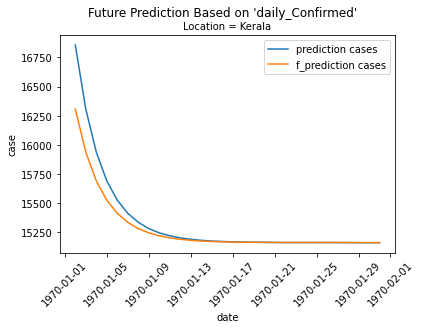

In [540]:
plt.plot(
    future_index3,
    future_predict_flatten3,
    label='prediction cases'
)
plt.plot(
    future_index3,
    f_future_predict_flatten3,
    label='f_prediction cases'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

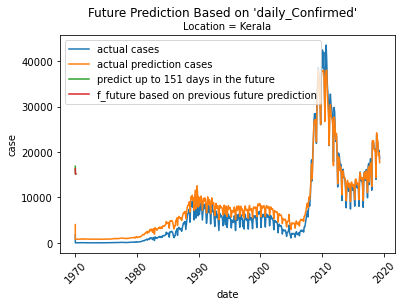

In [541]:
plt.plot(
    cases3.index[:len(X_all_flatten3)],
    X_all_flatten3,
    label='actual cases'
)
plt.plot(
    cases3.index[:len(X_all_flatten3)],
    all_predict_flatten3,
    label='actual prediction cases'
)
plt.plot(
    future_index3,
    future_predict_flatten3,
    label='predict up to ' + str(days_to_predict) + ' days in the future'
)
plt.plot(
    future_index3,
    f_future_predict_flatten3,
    label='f_future based on previous future prediction'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [542]:
#kerala
def accuracy(DataY,preds):
    count = 0
    for i in range(len(DataY)):
        if( (preds[i] - DataY[i])/DataY[i]<95):
            count += 1
           
    return count/len(DataY)
accuracy( Y_all_flatten3, 
        all_predict_flatten3)

0.9298245614035088